# Modelling

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
import seaborn as sns
import pickle
import json

In [2]:
# load cleaned train and validation dataset
df = pd.read_csv('TrainAndValidCleaned.csv', low_memory=False)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 20 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   SalesID             412698 non-null  int64  
 1   SalePrice           412698 non-null  float64
 2   MachineID           412698 non-null  int64  
 3   ModelID             412698 non-null  int64  
 4   datasource          412698 non-null  int64  
 5   auctioneerID        412698 non-null  float64
 6   YearMade            412698 non-null  float64
 7   fiModelDesc         412698 non-null  int64  
 8   fiBaseModel         412698 non-null  int64  
 9   fiSecondaryDesc     412698 non-null  int64  
 10  fiProductClassDesc  412698 non-null  int64  
 11  state               412698 non-null  int64  
 12  ProductGroup        412698 non-null  int64  
 13  ProductGroupDesc    412698 non-null  int64  
 14  Enclosure           412698 non-null  int64  
 15  Hydraulics          412698 non-nul

## Cleaning data: dropping unnecessary features

Let's check if some features are correlated with each other. These which are correlated should be dropped because they dont breing any value to the model

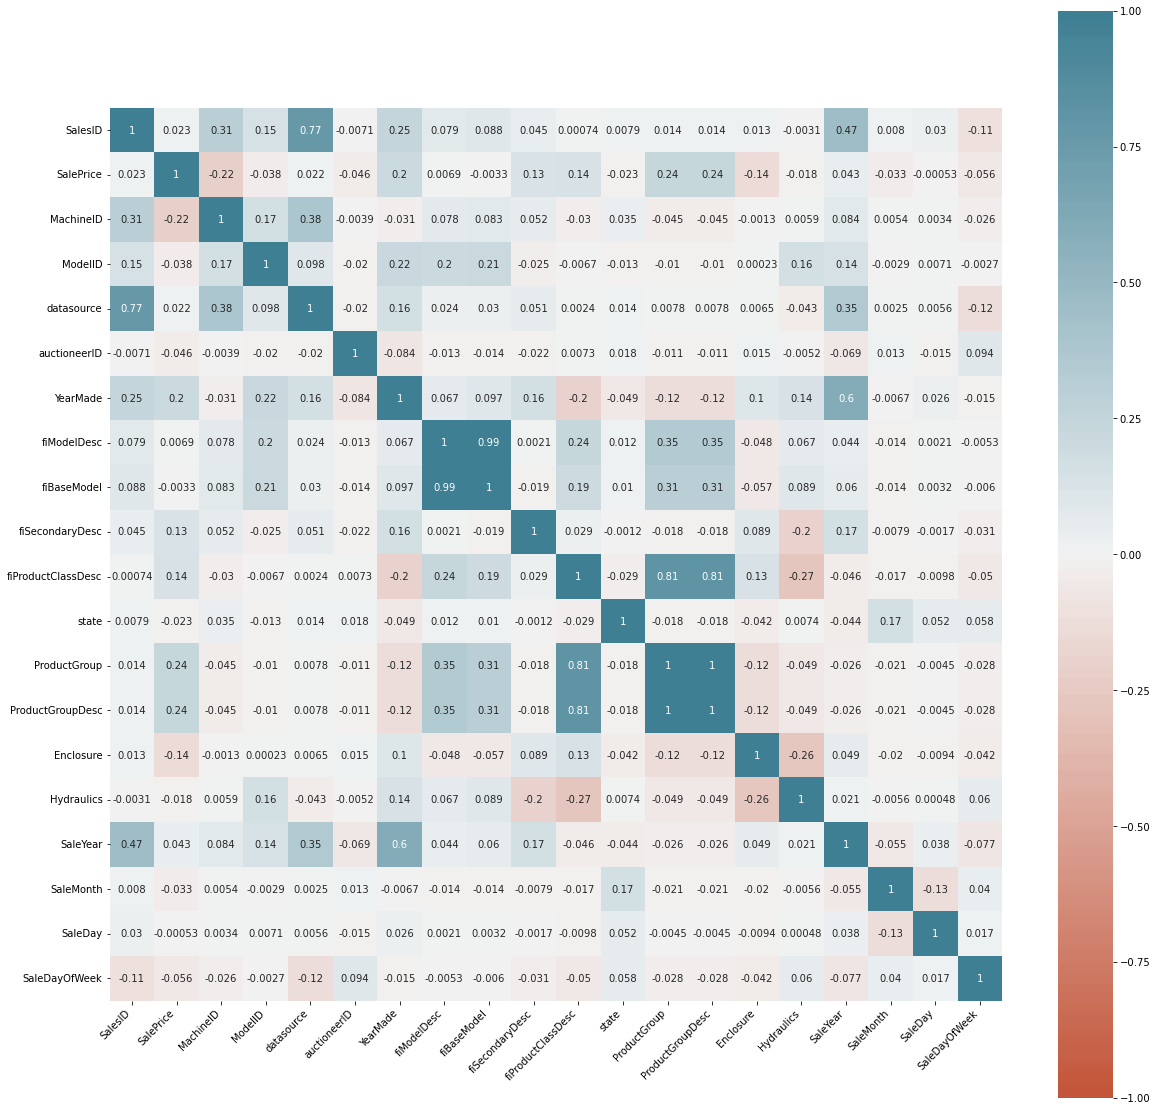

In [4]:
corr = df.corr()

fig, ax = plt.subplots(figsize=(20, 20))
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    annot=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)

plt.show()

In [5]:
# We can easily drop: 'ProductGroupDesc', 'fiModelDesc' because they are correlated with other features
df = df.drop(['ProductGroupDesc', 'fiModelDesc'], axis=1)

### Split data into training and valid sets

In [6]:
train, valid = train_test_split(df, test_size=0.2)
X_train, y_train = train.drop(["SalePrice"], axis=1), train['SalePrice']
X_valid, y_valid = valid.drop(["SalePrice"], axis=1), valid['SalePrice']

## Base-case model training
They are many possible models and algorithms that could solve the task of predicting prices based on multiple features. In this notebook the application of the Random Forest Regressor (which is one of the most common approaches for this type of problem) is shown.

In [7]:
# n_estimators, default=100. The number of trees in the forest.
# Popular integer random seeds are 0 and 42
base_model = RandomForestRegressor(random_state=42)
base_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

### Measuring base-case model performance

Unlike classification, one cannot use classification accuracy to evaluate the predictions made by a regression model. Here the model performance will be measured by: 
- Mean Squared Error (MSE). 
- The Root Mean Squared Log Error (RMSLE) 
- R2

In [8]:
def evaluate(model, test_features, test_labels):
    y_true = test_labels
    y_pred = model.predict(test_features)
    print('MSE:', sklearn.metrics.mean_squared_error(y_true, y_pred, squared=True))
    print('RMSLE:', np.sqrt(mean_squared_log_error(y_true,y_pred)))
    print('R2 score:', r2_score(y_true,y_pred))

In [9]:
# Now let's measure model performance on the validation set
evaluate(base_model, X_valid, y_valid)

MSE: 54789302.72837895
RMSLE: 0.22487971226134001
R2 score: 0.8978493045074089


In [10]:
# We can also check what is the performance on the training set
evaluate(base_model, X_train, y_train)

MSE: 7842185.395127595
RMSLE: 0.09273241943264533
R2 score: 0.9853508010840304


## Model tuning
The base-case model performs well on default configuration. Let's check if the model can be optimized

### Importance of features

In [11]:
# Make a function that trains the model (with use of different params) and returns r2 scores
def train_and_measure_perf(X_train, y_train, X_valid, y_valid, n_estimators=100):
    model = RandomForestRegressor(n_estimators=n_estimators, random_state=42)
    model.fit(X_train, y_train)
    
    y_true = y_valid
    y_pred = model.predict(X_valid)
    r2_valid = r2_score(y_true,y_pred)
    
    y_true = y_train
    y_pred = model.predict(X_train)
    r2_train = r2_score(y_true,y_pred)
    
    return r2_train, r2_valid

# Helper function for plotting feature importance
def plot_features2(columns, importances, n=20):
    fig, ax = plt.subplots(figsize=(20, 15))
    df = (pd.DataFrame({"features": columns,
                        "feature_importance": importances})
          .sort_values("feature_importance", ascending=False)
          .reset_index(drop=True))
    
    sns.barplot(x="feature_importance",
                y="features",
                data=df[:n],
                orient="h")
    ax.set_ylabel("Features")
    ax.set_xlabel("Features Importance")
    
    plt.show()
    
# Function that returns top feature names. Number: number of top features 
def get_most_important_cats(features, importances, number):
    ind = np.argpartition(importances, -number)[-number:]
    return features[ind]

Let's check importance of features first. Which of the parameters should be taken into consideration for the final model?

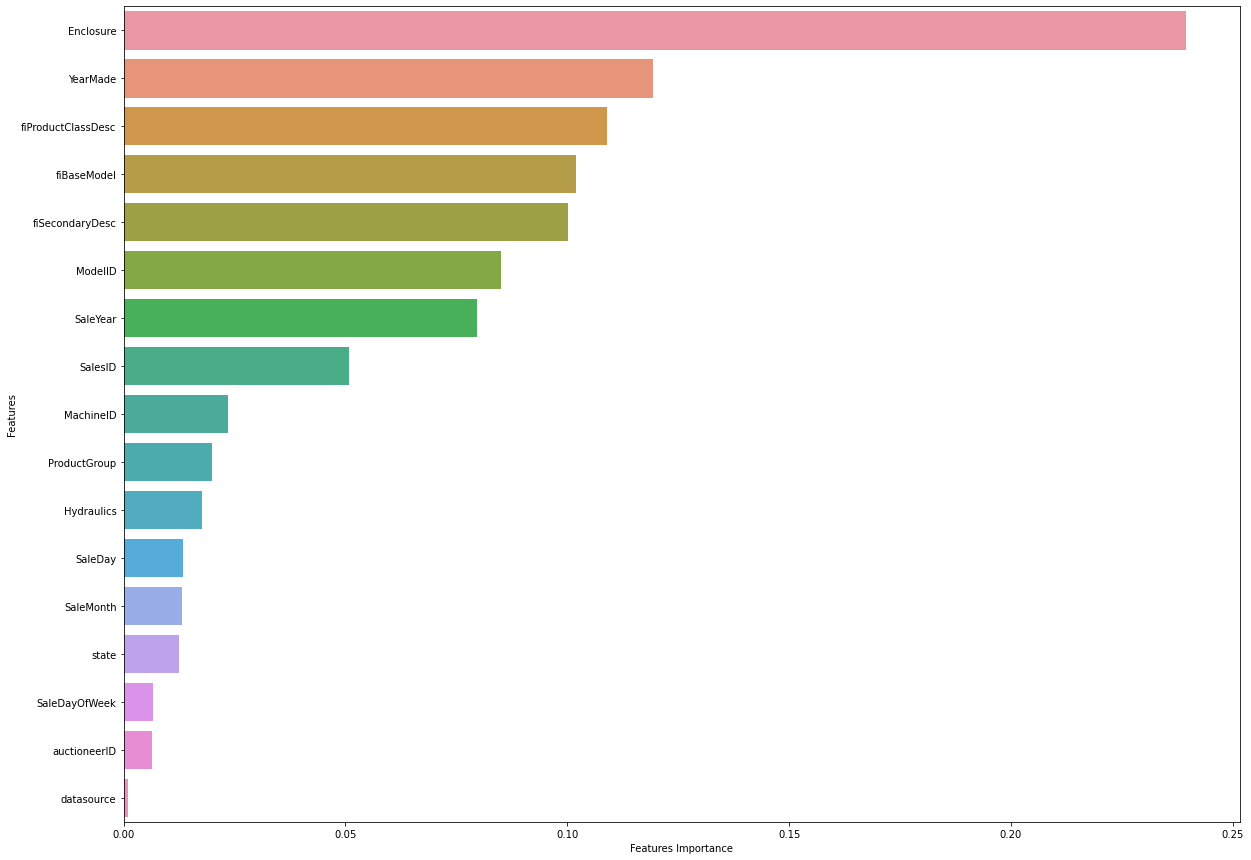

In [12]:
plot_features2(X_train.columns, base_model.feature_importances_,len(X_train.columns))

Let's test model performance on certain number of top features. We use max features = 10 to speed up the process

In [13]:
max_features = 10
r2_scores = []
print('number of model features,', '[r2_train,', 'r2_valid]')
for n in range(1,max_features):
    cats = get_most_important_cats(X_train.columns, base_model.feature_importances_, n)
    X_t = X_train[cats]
    X_v = X_valid[cats]
    r2_train, r2_valid = train_and_measure_perf(X_t, y_train, X_v, y_valid)
    r2_scores.append([r2_train, r2_valid])
    print('Features:', cats.values)
    print(n, [r2_train, r2_valid])

number of model features, [r2_train, r2_valid]
Features: ['Enclosure']
1 [0.23953037559153334, 0.23827138090969724]
Features: ['YearMade' 'Enclosure']
2 [0.2834444834892579, 0.28157867937374315]
Features: ['fiProductClassDesc' 'YearMade' 'Enclosure']
3 [0.6852662835043296, 0.6690820424162949]
Features: ['fiBaseModel' 'fiProductClassDesc' 'YearMade' 'Enclosure']
4 [0.7825322474991148, 0.7537736091185757]
Features: ['fiSecondaryDesc' 'Enclosure' 'YearMade' 'fiBaseModel'
 'fiProductClassDesc']
5 [0.7945855527893366, 0.7621189397694473]
Features: ['ModelID' 'fiSecondaryDesc' 'Enclosure' 'YearMade' 'fiBaseModel'
 'fiProductClassDesc']
6 [0.8063764763722419, 0.7658477012309607]
Features: ['SaleYear' 'ModelID' 'fiSecondaryDesc' 'Enclosure' 'YearMade'
 'fiBaseModel' 'fiProductClassDesc']
7 [0.9462145786422927, 0.8854737687369648]
Features: ['SalesID' 'fiSecondaryDesc' 'Enclosure' 'fiBaseModel' 'SaleYear'
 'YearMade' 'ModelID' 'fiProductClassDesc']
8 [0.9834350456977979, 0.8827555734205985]
Fea

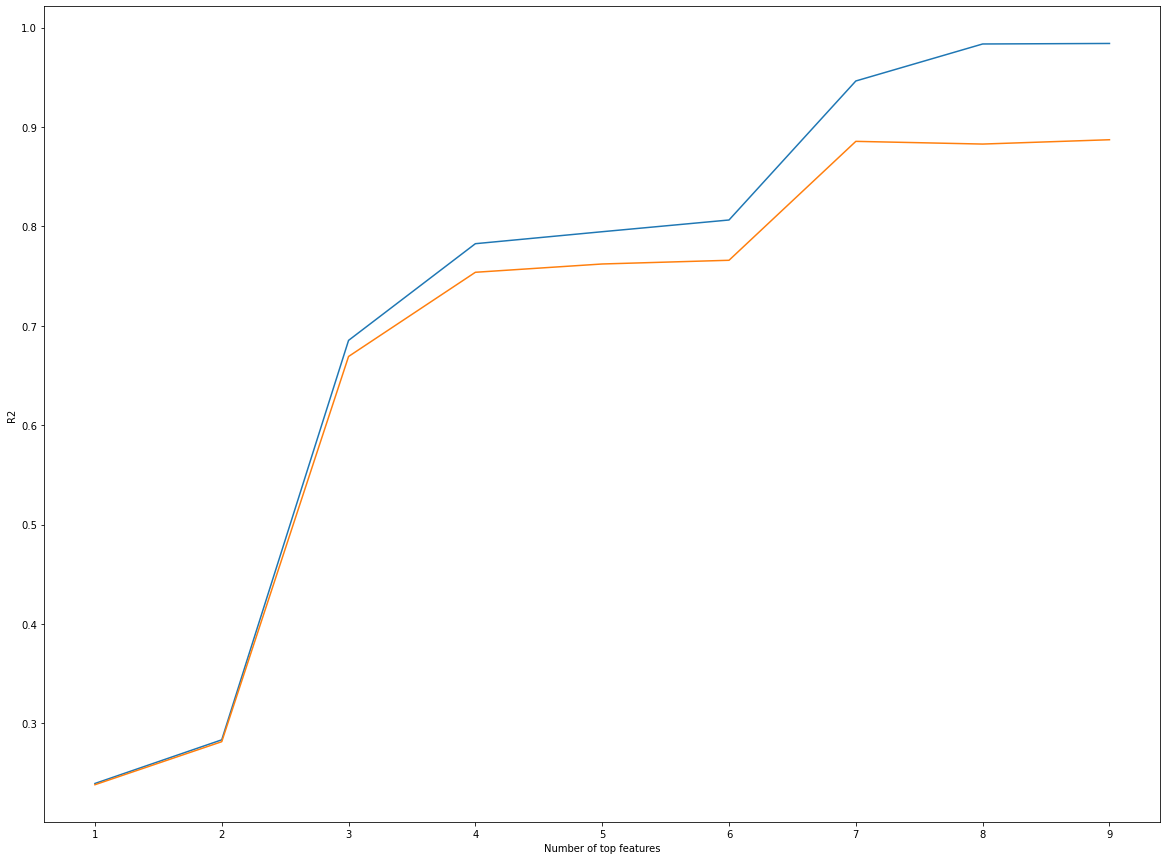

In [14]:
# Plot performance depending on number of features (orange: valid, blue: training set performance)
fig, ax = plt.subplots(figsize=(20, 15))
plt.plot([*range(1,10)], r2_scores)
ax.set_ylabel("R2")
ax.set_xlabel("Number of top features")
plt.show()

The test shows the highest prcision score (on valid data) is obtained if number of features is approximately as large as possible. The question is if we want to keep all possible features in the model. The higher number of parameters result in slower and bigger model and more complicated interaction with the model.

One can observe the R2 value (validation set) reaches platou after 7'th top feature. Only performance at training set increases after 7'th feature (risk of overfitting). It is therefore suggested that the final model should take only the top 7 features as input and do not consider the remaining features.

In [26]:
# The top 7 important features are:
top7_cats = get_most_important_cats(X_train.columns, base_model.feature_importances_, 7)
top7_cats

Index(['SaleYear', 'ModelID', 'fiSecondaryDesc', 'Enclosure', 'YearMade',
       'fiBaseModel', 'fiProductClassDesc'],
      dtype='object')

### The number of trees in the forest
Now the model tree number (number of estimatiors) is checked for the optimal value. NB! top 7 features are used for this experiment

In [27]:
# Let's test performance of the model using different tree depths (n_estimator_list)
n_estimator_list = [1,3,5,10,20,30,50,100]
r2_scores_t = []
print('tree depth,', '[r2_train,', 'r2_valid]')
for n in n_estimator_list:
    X_t = X_train[top7_cats]
    X_v = X_valid[top7_cats]
    [r2_train, r2_valid] = train_and_measure_perf(X_t, y_train, X_v, y_valid, n)
    r2_scores_t.append([r2_train, r2_valid])
    print(n, [r2_train, r2_valid])

tree depth, [r2_train, r2_valid]
1 [0.9106318870629527, 0.8329549834732946]
3 [0.9343444971749826, 0.8673582423816287]
5 [0.9391067899704044, 0.8746453496481581]
10 [0.9428606817912344, 0.8804988721010648]
20 [0.9447410056410246, 0.8834316430217748]
30 [0.945364763081341, 0.884214227806755]
50 [0.9458583048047676, 0.8849426129716629]
100 [0.9462145786422927, 0.8854737687369648]


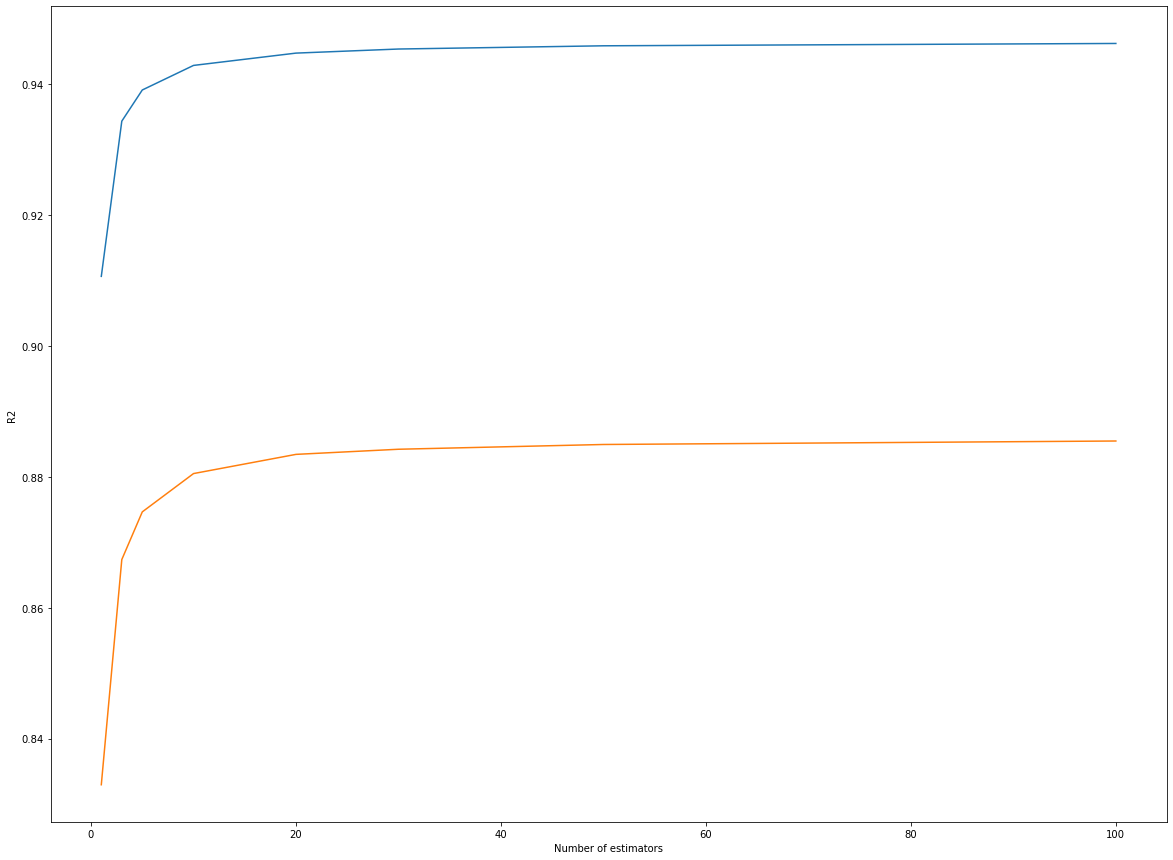

In [28]:
fig, ax = plt.subplots(figsize=(20, 15))
plt.plot([*n_estimator_list], r2_scores_t) # orange: valid, blue: training set performance
ax.set_ylabel("R2")
ax.set_xlabel("Number of estimators")
plt.show()

The best results are obtained if number of estimators is as high as possible. The downside of high estimator number is that it increases the model complexity. The performance reaches plateou at about 20, so it is suggested to use number of estimators = 20 in the final model. Let's train once again with desired combination of feature number and tree depth.

In [29]:
model = RandomForestRegressor(n_estimators=20, random_state=42)
model.fit(X_train[top7_cats], y_train)
evaluate(model, X_valid[top7_cats], y_valid)

MSE: 62522325.1611923
RMSLE: 0.23701481847309092
R2 score: 0.8834316430217748


The model R2 score is about 0.88

In [30]:
# Let's dump the model as a pickle pile
a_file = open("model.pkl", "wb")
pickle.dump(model, a_file)
a_file.close()

### Tuning using RandomizedSearchCV

In [31]:
# Another, and often the best option for model fine tuning if use of RandomizedSearchCV 
# or GridSearchCV. The downsite is that the tunning takes a lot of time.
# Below example that can be used for tuning this model

#from sklearn.model_selection import RandomizedSearchCV

# # Different RandomForestClassifier hyperparameters
# rf_grid = {"n_estimators": np.arange(10, 100, 10), # The number of trees in the forest.
#            "max_depth": [None, 3, 5, 10],
#            "min_samples_split": np.arange(2, 20, 2),
#            "min_samples_leaf": np.arange(1, 20, 2),
#            "max_features": ['sqrt', 'log2', None], # The number of features to consider when looking for the best split
#            "max_samples": [None]
#           }

# rs_model = RandomizedSearchCV(RandomForestRegressor(),
#                               param_distributions=rf_grid,
#                               #n_iter=10,
#                               #verbose=True,
#                               #n_jobs=-1 # using all processors
#                              )

# # Hyperparameters used for the base model
# base_model.get_params()
# # Fit the model
# rs_model.fit(X_train, y_train)
# # Print combination of the best parameters
# rs_model.best_params_
# # Evaluate the model
# evaluate(rs_model, X_valid, y_valid)

### Make predictions on dummy user data

In [32]:
X_valid[top7_cats]

,SaleYear,ModelID,fiSecondaryDesc,Enclosure,YearMade,fiBaseModel,fiProductClassDesc
405761,2012,6949,27,4,1996.0,1832,71
193981,2006,4579,81,4,1998.0,93,70
218019,1994,8742,27,0,1985.0,1806,14
380257,2009,7019,27,4,2004.0,126,40
93230,1993,7110,27,0,1988.0,244,1
...,...,...,...,...,...,...,...
348954,2007,259,51,4,1996.0,710,49
10387,2004,1333,21,2,1997.0,207,21
311737,2008,3537,18,2,1994.0,244,1
179186,2008,4701,56,4,1999.0,306,59


In [33]:
# Let's define some dummy data that a user can type
YearMade = 1990
fiBaseModel = 100
fiSecondaryDesc = 0
SaleYear = 2022
fiProductClassDesc = 1
Enclosure = 2
ModelID = 5

d = {
    'SaleYear':SaleYear,
    'ModelID': ModelID,
    'fiSecondaryDesc':fiSecondaryDesc,
    'Enclosure':Enclosure,
    'YearMade':YearMade, 
    'fiBaseModel':fiBaseModel, 
    'fiProductClassDesc':fiProductClassDesc, 
    }

df_test = pd.DataFrame(d, index=[0])
df_test

,SaleYear,ModelID,fiSecondaryDesc,Enclosure,YearMade,fiBaseModel,fiProductClassDesc
0,2022,5,0,2,1990,100,1


In [34]:
# The following is the price for given feature values
y_test = model.predict(df_test)
print("${:.0f}". format(y_test[0]))

$14250


In [41]:
# Export category-code dictionary for relevant categories so a user knows codes. 
# The codes are obtained from a dictionary that was exported in 'Data_cleaning_exploration.ipynb'
cats_codes = pickle.load(open('cats_codes.pkl', 'rb'))
keys = ('fiBaseModel','fiSecondaryDesc', 'Enclosure','fiProductClassDesc')
d1 = {k: cats_codes[k] for k in keys}
a_file = open("../templates/category_description.json", "w")
json.dump(d1, a_file, indent=2)
a_file.close()